In [1]:
USE_GPU = False

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug
import time

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=["nose", "right_ankle"])
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=["nose", "right_ankle"])
dataset_val.prepare()

Will use images in A:/Programming/DeepLearningDatasets/coco/train2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=9.07s)
creating index...
index created!
Will use images in A:/Programming/DeepLearningDatasets/coco/val2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [3]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_val.num_classes
    NUM_KEYPOINTS = dataset_val.num_kp_classes
    #MAX_GT_INSTANCES = 2   
inference_config = InferenceConfig()
#inference_config.display()

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 2)                min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 2)                min: 224777.00000  max: 822766.00000  int32
masks                    shape: (1, 2, 1024, 1024)    min:    0.00000  max:    1.00000  bool


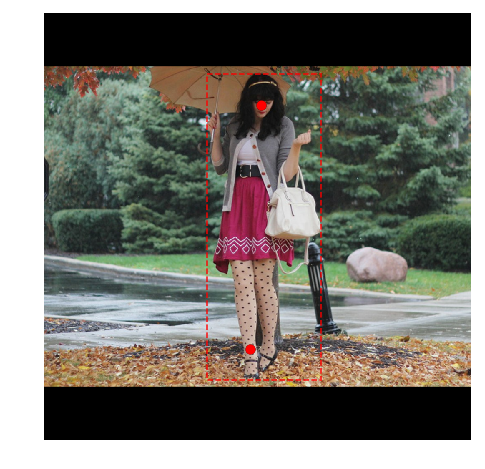

In [4]:
# Load a test image
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, image_id)

masks = utils.sparse_to_dense_masks(gt_kp_masks, image.shape)

log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)
log("masks", masks)


visualize.display_keypoints(image, gt_bbox, masks, gt_kp_ids,
                            #skeleton=dataset_val.skeleton,
                            figsize=(8, 8))

In [5]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1 # IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 1
    VALIDATION_STEPS = 1
    
    TRAIN_ROIS_PER_IMAGE = 100
    #MAX_GT_INSTANCES = 1
    
    IMAGE_MIN_DIM = 1024 #if USE_GPU else 64
    IMAGE_MAX_DIM = 1024 #if USE_GPU else 64

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

In [6]:
importlib.reload(modellib)

# Create model
print("Creating model...")
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
    
# Do a quick forward pass
print("Training network heads...")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers="heads",
            augmentation=None)

Creating model...

build:
input_gt_boxes.shape (?, ?, 4)
input_gt_kp_ids.shape (?, ?, 2)
input_gt_masks.shape (?, ?, 2)
gt_masks.shape (?, 2)
masks.shape (?, 2)
kps_1d_indices.shape (?,)
kps_x.shape (?, ?)
kps_x.shape (?, ?)
resized_kps_x.shape (?, ?)
masks.shape (?, ?, 2)
target_mask.shape (1, ?, ?, ?)
target_mask.dtype <dtype: 'int32'>
mrcnn_mask.shape (?, 100, 2, 28, 28)

mrcnn_mask_loss_graph shapes:
target_masks.shape (1, ?, ?, ?)
target_masks.dtype <dtype: 'int32'>
target_kp_ids.shape (1, ?, ?)
pred_masks.shape (?, 100, 2, 28, 28)
valid_kps_idx.shape (?,)
y_true.shape (?,)
y_true.shape (?,)
y_pred.shape (?, ?)


mrcnn_mask_loss_graph shapes:
target_masks.shape (?, 100, 2, 2)
target_masks.dtype <dtype: 'int32'>
target_kp_ids.shape (?, 2)
pred_masks.shape (?, 100, 2, 28, 28)
valid_kps_idx.shape (?,)
y_true.shape (?,)
y_true.shape (?,)
y_pred.shape (?, ?)

Training network heads...

Starting at epoch 0. LR=0.001

Checkpoint Path: A:\Programming\Pose_RCNN\logs\coco_keypoints20180603T

c:\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
1/1 [==============================] - 34s 34s/step - loss: 1.5442 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 0.5762 - mrcnn_bbox_loss: 0.9112 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.5399 - val_rpn_class_loss: 0.0556 - val_rpn_bbox_loss: 0.4022 - val_mrcnn_bbox_loss: 1.0822 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 27s 27s/step - loss: 8.9626 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 1.2883 - mrcnn_bbox_loss: 0.9566 - mrcnn_mask_loss: 6.6895 - val_loss: 1.4467 - val_rpn_class_loss: 0.1015 - val_rpn_bbox_loss: 0.5220 - val_mrcnn_bbox_loss: 0.8233 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/10


KeyboardInterrupt: 

In [ ]:
import itertools
val_generator = modellib.data_generator(dataset_val, config, shuffle=False,
                                        batch_size=config.BATCH_SIZE)

inputs, outputs = next(itertools.islice(val_generator, 5, 5 + 1))

In [ ]:
print(model.keras_model.input)

## Verify Inputs

In [ ]:
importlib.reload(utils)

input_image = modellib.unmold_image(inputs[0][0], config)
input_image_meta = inputs[1][0]
input_gt_sparse_masks = inputs[7][0][:1]
input_gt_kp_ids = inputs[5][0][:1]
input_gt_boxes = inputs[6][0][:1]

input_gt_masks = utils.sparse_to_dense_masks(input_gt_sparse_masks, input_image.shape)

print("Image ID %i" % input_image_meta[0])

visualize.display_keypoints(input_image, input_gt_boxes, input_gt_masks, input_gt_kp_ids,
                            skeleton=dataset_val.skeleton,
                            figsize=(8, 8))

In [ ]:
image_id = int(input_image_meta[0])

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, image_id)

masks = utils.sparse_to_dense_masks(gt_kp_masks, image.shape)

visualize.display_keypoints(image, gt_bbox, masks, gt_kp_ids,
                            skeleton=dataset_val.skeleton,
                            figsize=(8, 8))

In [ ]:
[layer.name for layer in model.keras_model.layers]

In [ ]:
from keras.models import Model

intermediate_layer_model = Model(inputs=model.keras_model.input,
                                 outputs=model.keras_model.get_layer("mrcnn_mask").output)
mrcnn_mask = intermediate_layer_model.predict(inputs)

In [ ]:
log("mrcnn_mask", mrcnn_mask)

%matplotlib inline
import matplotlib.pyplot as plt

n = np.sqrt(inference_config.NUM_KEYPOINTS)
_, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
if n <= 1: axes = np.array(axes)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= inference_config.NUM_KEYPOINTS: continue
    #x, y = i % 4, i // 4
    
    ax.set_title(dataset_train.kp_class_names[i+1])
    ax.imshow(mrcnn_mask[0, 0, :, :, i])


plt.show()

In [ ]:
"""gt_masks[[516824 765619][449198 0][475658 0][503099 0][549139 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0][0 0]][100 2]
roi_gt_box_assignment[2 1 4 1 4 1 1 0 0 0 1 0 4 1 0 0 1 1 1 4 2 1 0 3 2 0 0 3 2 3 1 1 0][33]boxes[[[0.420332342][0.441837728][0.537634432][0.549364626]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.459433049][0.166177914][0.685239494][0.314760506]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.459433049][0.166177914][0.685239494][0.314760506]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.459433049][0.166177914][0.685239494][0.314760506]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.459433049][0.166177914][0.685239494][0.314760506]][[0.420332342][0.441837728][0.537634432][0.549364626]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.441837728][0.252199411][0.619745851][0.379276633]][[0.420332342][0.441837728][0.537634432][0.549364626]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.448680341][0.620723367][0.798631489][0.812316716]][[0.441837728][0.252199411][0.619745851][0.379276633]][[0.420332342][0.441837728][0.537634432][0.549364626]][[0.441837728][0.252199411][0.619745851][0.379276633]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.394916922][0.64809382][0.533724368][0.739002943]][[0.448680341][0.620723367][0.798631489][0.812316716]]][33 4 1]

masks[[475658 0][449198 0][549139 0][449198 0][549139 0][449198 0][449198 0][516824 765619][516824 765619][516824 765619][449198 0][516824 765619][549139 0][449198 0][516824 765619][516824 765619][449198 0][449198 0][449198 0][549139 0][475658 0][449198 0][516824 765619][503099 0][475658 0][516824 765619][516824 765619][503099 0][475658 0][503099 0][449198 0][449198 0][516824 765619]][33 2]
kps_1d_indices[475658 0 449198 0 549139 0 449198 0 549139 0 449198 0 449198 0 516824 765619 516824 765619 516824 765619 449198 0 516824 765619 549139 0 449198 0 516824 765619 516824 765619 449198 0 449198 0 449198 0 549139 0 475658 0 449198 0 516824 765619 503099 0 475658 0 516824 765619 516824 765619 503099 0 475658 0 503099 0 449198 0 449198 0 516824 765619][66]
kps_y:0[0.509765625 0 0.669921875 0 0.268554688 0 0.669921875 0 0.268554688 0 0.669921875 0 0.669921875 0 0.7109375 0.674804688 0.7109375 0.674804688 0.7109375 0.674804688 0.669921875 0 0.7109375 0.674804688 0.268554688 0 0.669921875 0 0.7109375 0.674804688 0.7109375 0.674804688 0.669921875 0 0.669921875 0 0.669921875 0 0.268554688 0 0.509765625 0 0.669921875 0 0.7109375 0.674804688 0.307617188 0 0.509765625 0 0.7109375 0.674804688 0.7109375 0.674804688 0.307617188 0 0.509765625 0 0.307617188 0 0.669921875 0 0.669921875 0 0.7109375 0.674804688][66]
kps_x:0[0.453125 0 0.427734375 0 0.5234375 0 0.427734375 0 0.5234375 0 0.427734375 0 0.427734375 0 0.4921875 0.729492188 0.4921875 0.729492188 0.4921875 0.729492188 0.427734375 0 0.4921875 0.729492188 0.5234375 0 0.427734375 0 0.4921875 0.729492188 0.4921875 0.729492188 0.427734375 0 0.427734375 0 0.427734375 0 0.5234375 0 0.453125 0 0.427734375 0 0.4921875 0.729492188 0.479492188 0 0.453125 0 0.4921875 0.729492188 0.4921875 0.729492188 0.479492188 0 0.453125 0 0.479492188 0 0.427734375 0 0.427734375 0 0.4921875 0.729492188][66]
kps_y:1[[0.509765625 0][0.669921875 0][0.268554688 0][0.669921875 0][0.268554688 0][0.669921875 0][0.669921875 0][0.7109375 0.674804688][0.7109375 0.674804688][0.7109375 0.674804688][0.669921875 0][0.7109375 0.674804688][0.268554688 0][0.669921875 0][0.7109375 0.674804688][0.7109375 0.674804688][0.669921875 0][0.669921875 0][0.669921875 0][0.268554688 0][0.509765625 0][0.669921875 0][0.7109375 0.674804688][0.307617188 0][0.509765625 0][0.7109375 0.674804688][0.7109375 0.674804688][0.307617188 0][0.509765625 0][0.307617188 0][0.669921875 0][0.669921875 0][0.7109375 0.674804688]][33 2]
kps_x:1[[0.453125 0][0.427734375 0][0.5234375 0][0.427734375 0][0.5234375 0][0.427734375 0][0.427734375 0][0.4921875 0.729492188][0.4921875 0.729492188][0.4921875 0.729492188][0.427734375 0][0.4921875 0.729492188][0.5234375 0][0.427734375 0][0.4921875 0.729492188][0.4921875 0.729492188][0.427734375 0][0.427734375 0][0.427734375 0][0.5234375 0][0.453125 0][0.427734375 0][0.4921875 0.729492188][0.479492188 0][0.453125 0][0.4921875 0.729492188][0.4921875 0.729492188][0.479492188 0][0.453125 0][0.479492188 0][0.427734375 0][0.427734375 0][0.4921875 0.729492188]][33 2]
kps_y:2[[0.0894332826 -0.420332342][0.275004953 -0.394916922][-0.190878361 -0.459433049][0.275004953 -0.394916922][-0.190878361 -0.459433049][0.275004953 -0.394916922][0.275004953 -0.394916922][0.262257159 0.226124346][0.262257159 0.226124346][0.262257159 0.226124346][0.275004953 -0.394916922][0.262257159 0.226124346][-0.190878361 -0.459433049][0.275004953 -0.394916922][0.262257159 0.226124346][0.262257159 0.226124346][0.275004953 -0.394916922][0.275004953 -0.394916922][0.275004953 -0.394916922][-0.190878361 -0.459433049][0.0894332826 -0.420332342][0.275004953 -0.394916922][0.262257159 0.226124346][-0.134220541 -0.441837728][0.0894332826 -0.420332342][0.262257159 0.226124346][0.262257159 0.226124346][-0.134220541 -0.441837728][0.0894332826 -0.420332342][-0.134220541 -0.441837728][0.275004953 -0.394916922][0.275004953 -0.394916922][0.262257159 0.226124346]][33 2]
kps_x:2[[0.011287272 -0.441837728][-0.220359445 -0.64809382][0.357259572 -0.166177914][-0.220359445 -0.64809382][0.357259572 -0.166177914][-0.220359445 -0.64809382][-0.220359445 -0.64809382][-0.128535867 0.108768821][-0.128535867 0.108768821][-0.128535867 0.108768821][-0.220359445 -0.64809382][-0.128535867 0.108768821][0.357259572 -0.166177914][-0.220359445 -0.64809382][-0.128535867 0.108768821][-0.128535867 0.108768821][-0.220359445 -0.64809382][-0.220359445 -0.64809382][-0.220359445 -0.64809382][0.357259572 -0.166177914][0.011287272 -0.441837728][-0.220359445 -0.64809382][-0.128535867 0.108768821][0.227292776 -0.252199411][0.011287272 -0.441837728][-0.128535867 0.108768821][-0.128535867 0.108768821][0.227292776 -0.252199411][0.011287272 -0.441837728][0.227292776 -0.252199411][-0.220359445 -0.64809382][-0.220359445 -0.64809382][-0.128535867 0.108768821]][33 2]resized_kps_y[[21 -100][55 -79][-23 -56][55 -79][-23 -56][55 -79][55 -79][20 18][20 18][20 18][55 -79][20 18][-23 -56][55 -79][20 18][20 18][55 -79][55 -79][55 -79][-23 -56][21 -100][55 -79][20 18][-21 -69][21 -100][20 18][20 18][-21 -69][21 -100][-21 -69][55 -79][55 -79][20 18]][33 2]

resized_kps_x[[2 -115][-67 -199][67 -31][-67 -199][67 -31][-67 -199][-67 -199][-18 15][-18 15][-18 15][-67 -199][-18 15][67 -31][-67 -199][-18 15][-18 15][-67 -199][-67 -199][-67 -199][67 -31][2 -115][-67 -199][-18 15][50 -55][2 -115][-18 15][-18 15][50 -55][2 -115][50 -55][-67 -199][-67 -199][-18 15]][33 2]
valid_kps_idx[0 8 10 12 15 19 21 26 29 31 33 35 37 42][14]
kps_indices[590 519 519 519 519 519 519 590 519 590 519 519 590 519][14]"""